In [1]:
import pickle
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import callbacks, layers, Sequential
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from dataflow import Flow

In [2]:
version = "5.0.5"
fname = f'preselected_feat_v{version}_equalRatio_restrictedSideband'
# Change this!

In [3]:
data = Flow(None, None, None, f'csv/{fname}.csv')
df = data.get_combined_data()

In [4]:
df.columns

Index(['Lb_PT', 'Lb_IPCHI2_OWNPV', 'Lb_ENDVERTEX_CHI2', 'Lb_HOP',
       'LStar_ORIVX_CHI2', 'LStar_DIRA_OWNPV', 'JPs_FD_ORIVX', 'p_ETA',
       'K_ETA', 'L1_ETA', 'L2_ETA', 'Lb_IP01', 'Lb_IP23', 'Lb_IP_OWNPV',
       'p_TRACK_VeloCHI2NDOF', 'category', 'ABS_ARTANH_PZ_P',
       'MAG_ARSINH_PY_PT', 'SUM_CONE_ISO', 'SUM_LIPCHI2', 'LB_TRACKISO',
       'LN_COS_THETA', 'LN_LB_MINIPCHI2', 'LN_COS_LBDIRA',
       'LN_JPs_DIRA_TOPPV'],
      dtype='object')

In [6]:
custom_callbacks = [
    callbacks.EarlyStopping(patience=20, min_delta=0.0005, restore_best_weights=True), 
    callbacks.ReduceLROnPlateau(patience=5, factor=0.2, min_lr=0.001)
    ]

def compile_model(input_shape):
    model = Sequential([
        layers.Dense(16, activation='relu', input_shape=input_shape, kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
    
    return model

In [7]:
def plot_history_curves(history, epochs, model_version='No version', savefig='', off=False):
    if type(history) != dict:
        history = history.history
    
    loss = history['loss']
    val_loss = history['val_loss']
    accuracy = history['binary_accuracy']
    val_accuracy = history['val_binary_accuracy']
    auc = history['auc']
    val_auc = history['val_auc']
    epoch_range = range(1, epochs+1, 1)    

    fig, ax = plt.subplots(1, 3, figsize=(22, 6))
    ax[0].plot(epoch_range, loss, 'r.', label='Training Loss')
    ax[0].plot(epoch_range, val_loss, 'b.', label='Validation Loss')
    ax[1].plot(epoch_range, accuracy, 'r.', label='Training Accuracy')
    ax[1].plot(epoch_range, val_accuracy, 'b.', label='Validation Accuracy')
    ax[2].plot(epoch_range, auc, 'r.', label='Training AUC')
    ax[2].plot(epoch_range, val_auc, 'b.', label='Validation AUC')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.title(model_version)
    plt.legend(frameon=False)
    if savefig != '':
        plt.savefig(savefig)
    if not off:
        plt.show()

def plot_history(model_version, savefig='', off=False):
    history = pickle.load(open(f'train_history/v{model_version}', "rb"))
    nepochs = len(history['loss'])
    plot_history_curves(history, nepochs, model_version, savefig, off)
    

In [8]:
def fit_model(model, train_data, val_data, model_version, callbacks=None, epochs=100, batch_size=512):
    model_history = model.fit(train_data[0], train_data[1], epochs=epochs, batch_size=batch_size, validation_data=val_data, callbacks=callbacks, verbose=1)
    with open(f'train_history/v{model_version}', 'wb') as file_pi:
        pickle.dump(model_history.history, file_pi)
    model.save(f'models/v{model_version}')

In [9]:
def roc_curve(history, y_train, y_val, mversion='No Version', savefig=False, off=False, excl_epochs=0):
    train_signal_eff = history['true_positives']/y_train.value_counts()[1]
    val_signal_eff = history['val_true_positives']/y_val.value_counts()[1]
    # What percentage of total signal events were identified as signal events

    train_background_rej = 1 - (history['false_positives'] / y_train.value_counts()[0])
    val_background_rej = 1 - (history['val_false_positives'] / y_val.value_counts()[0])
    # The number of true positives to total positives
    
    train_background_rej, val_background_rej = train_background_rej[excl_epochs:], val_background_rej[excl_epochs:]
    train_signal_eff, val_signal_eff = train_signal_eff[excl_epochs:], val_signal_eff[excl_epochs:]
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(train_signal_eff, train_background_rej,  label='Training', s=2)
    ax.scatter(val_signal_eff, val_background_rej, label='Validation', s=2)
    ax.set_ylabel('Background Rejection (1 - False Positive Rate)')
    ax.set_xlabel('Signal Efficiency (True Positive Rate)')
    plt.title(f'Model {mversion}')
    plt.legend()
    if savefig != False:
        plt.savefig(savefig)
    if not off:
        plt.show()

In [10]:
def run_all(data, version):
    # Give it a list of data objects
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = data.get_train_val_test_split()
    model = compile_model((X_train.shape[1],))
    fit_model(model, (X_train, y_train), (X_val, y_val), f'{version}', callbacks=custom_callbacks)
    plot_history(f'{version}', f'train_history_imgs/{version}.png', off=True)
    history = pickle.load(open(f'train_history/v{version}', "rb"))
    roc_curve(history, y_train, y_val, mversion=f'{version}', savefig=f'train_history_imgs/{version}_roc.png', off=True, excl_epochs=5)
    # Dont plot the first 5 epochs they are dumb
    

2022-02-24 13:42:15.795295: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-24 13:42:15.798454: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-24 13:42:15.927907: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-24 13:42:15.945722: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400145000 Hz


Epoch 1/100
43/43 [==============================] - 4s 37ms/step - loss: 0.9904 - binary_accuracy: 0.7504 - auc: 0.8344 - true_positives: 8093.0000 - true_negatives: 8291.0000 - false_positives: 2612.0000 - false_negatives: 2838.0000 - val_loss: 0.9251 - val_binary_accuracy: 0.8923 - val_auc: 0.9537 - val_true_positives: 3341.0000 - val_true_negatives: 3154.0000 - val_false_positives: 473.0000 - val_false_negatives: 311.0000
Epoch 2/100
43/43 [==============================] - 1s 17ms/step - loss: 0.7684 - binary_accuracy: 0.8645 - auc: 0.9346 - true_positives: 9436.0000 - true_negatives: 9440.0000 - false_positives: 1463.0000 - false_negatives: 1495.0000 - val_loss: 0.7439 - val_binary_accuracy: 0.9104 - val_auc: 0.9675 - val_true_positives: 3388.0000 - val_true_negatives: 3239.0000 - val_false_positives: 388.0000 - val_false_negatives: 264.0000
Epoch 3/100
43/43 [==============================] - 1s 15ms/step - loss: 0.6742 - binary_accuracy: 0.8858 - auc: 0.9503 - true_positives: 9

2022-02-24 13:43:41.124217: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/v5.0.5/assets


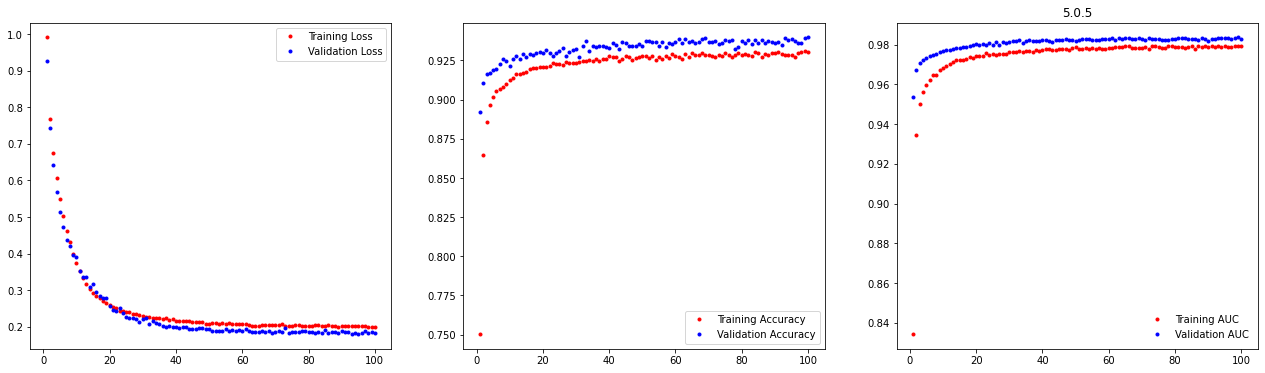

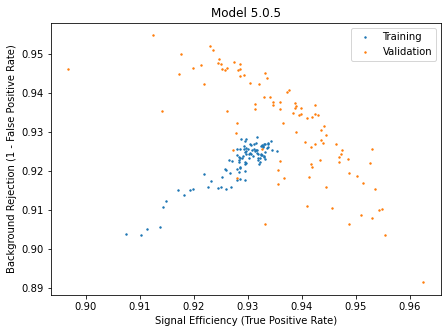

In [9]:
run_all(data, version)

## Plot Prediction Distribution 
Now we plot the distribution of the assigned probabilities across the train, validation and test data. Split colours via the dataset and solid or dashed being either signal or bakground. 

In [11]:
model = tf.keras.models.load_model(f'models/v{version}')
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data.get_train_val_test_split()

X_test_sig = X_test[y_test == 1]
X_test_bg = X_test[y_test == 0]

X_val_sig = X_val[y_val == 1]
X_val_bg = X_val[y_val == 0]

X_train_sig = X_train[y_train == 1]
X_train_bg = X_train[y_train == 0]

tests = model.predict(X_test_sig)
vals = model.predict(X_val_sig)
trains = model.predict(X_train_sig)
testb = model.predict(X_test_bg)
valb = model.predict(X_val_bg)
trainb = model.predict(X_train_bg)

2022-02-24 16:01:17.175311: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-24 16:01:17.180942: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-24 16:01:18.857957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-24 16:01:18.879661: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400145000 Hz


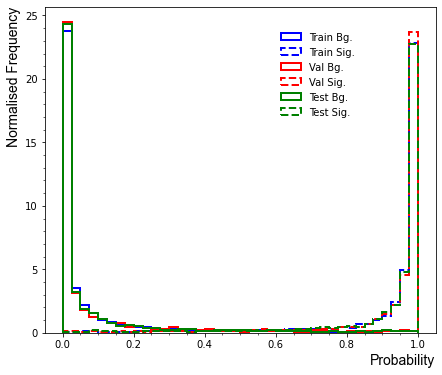

In [12]:
import numpy as np
from matplotlib.ticker import AutoMinorLocator

bins = np.linspace(0, 1, 41)
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

fonts = {'fontname':'Arial'}

ax.hist(trainb, bins=bins, histtype='step', label='Train Bg.', density=True, color='b', linewidth=2)
ax.hist(trains, bins=bins, histtype='step', label='Train Sig.', density=True, linestyle='dashed', color='b', linewidth=2)

ax.hist(valb, bins=bins, histtype='step', label='Val Bg.', density=True, color='r', linewidth=2)
ax.hist(vals, bins=bins, histtype='step', label='Val Sig.', density=True, linestyle='dashed', color='r', linewidth=2)

ax.hist(testb, bins=bins, histtype='step', label='Test Bg.', density=True, color='g', linewidth=2)
ax.hist(tests, bins=bins, histtype='step', label='Test Sig.', density=True, linestyle='dashed', color='g', linewidth=2)

plt.ylabel('Normalised Frequency', horizontalalignment='right', y=1.0, fontsize=14, **fonts)
plt.xlabel('Probability', horizontalalignment='right', x=1.0, fontsize=14, **fonts)
plt.legend(loc='upper center', bbox_to_anchor=(0.7, 0.95), ncol=1, fancybox=False, shadow=True, frameon=False)
#plt.savefig(f'v{version}_prob_dist.png')
plt.show()

# GREEN = #008000 (BACKGROUND)
# RED = #f40000 (SIGNAL)

# Punzi FOM Scan
Now we have a model which is producing a reasonable set of predictions that are fairly stable (hence the U-shaped graph) and are common for the training, validation and test features. As such we can now evaluate the Punzi FOM across the probability space to define where our cut point should be to maximise signal selection and background rejection efficiency. 

In [82]:
def calculate_punzi(model, labelled_data, prob_range=[0.3, 0.9], dpoints=150, significance=5, mass_range=[5200, 5800]):
    import numpy as np
    import pandas as pd
    
    probability_space = np.linspace(prob_range[0], prob_range[1], dpoints)
    # A region over which the Punzi FOM will be calculated
    
    labels = labelled_data['category'].to_numpy()
    nsignal_before = labelled_data['category'].value_counts()[1]
    # How many signal events are in the original data sample
    
    feature_cols = labelled_data.columns.to_list()
    feature_cols.remove('category')
    # Get all the columns with features and not the category
    predictions = model.predict(labelled_data[feature_cols])
    # Make predictions on the labelled data using the trained MVA model
    
    punzis = []
    for p in probability_space:
        # Iterate through each point in probability space
        
        # Each event is predicted a probability P. If P < p we say that,
        # it is background, else it is signal. I.e. p -> 1 in limit of high
        # background rejection, high purity sample 
        
        preds = np.squeeze(np.where(predictions < p, 0, 1))
        all = np.array([preds, labels]).T
        
        efficiency = len(np.squeeze(np.where((all == [1, 1]).all(axis=1)))) / nsignal_before
        # Truth matched signal i.e. model said it was signal and it actually was 
        
        background = len(np.squeeze(np.where((all == [1, 0]).all(axis=1))))
        # background you thought was signal, so did not reject i.e. it got through 
        
        #print(f'{p:.4f} {efficiency:.5f} {background}')
        # Background is how much background is left after the cut i.e. how much REAL background is left (incorrectly identified as signal)
        
        punzi = efficiency / (significance/2 + np.sqrt(background))
        # Calculate the Punzi as defined by LHCb 
        
        punzis.append(punzi)
        # Add this point to the array of Punzis
    return np.array(punzis), probability_space

In [73]:
test_df = X_test
test_df['category'] = y_test

val_df = X_val
val_df['category'] = y_val

train_df = X_train
train_df['category'] = y_train

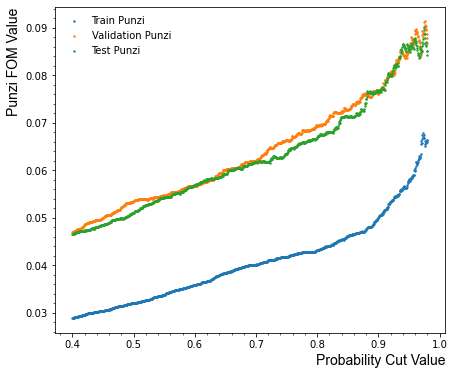

In [83]:
p1, probs1 = calculate_punzi(model, train_df, prob_range=[0.4, 0.98], dpoints=1000)
p2, probs2 = calculate_punzi(model, val_df, prob_range=[0.4, 0.98], dpoints=1000)
p3, probs3 = calculate_punzi(model, test_df, prob_range=[0.4, 0.98], dpoints=1000)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

fonts = {'fontname':'Arial'}

ax.scatter(probs1, p1, s=2, label='Train Punzi')
ax.scatter(probs2, p2, s=2, label='Validation Punzi')
ax.scatter(probs3, p3, s=2, label='Test Punzi')

plt.ylabel('Punzi FOM Value', horizontalalignment='right', y=1.0, fontsize=14, **fonts)
plt.xlabel('Probability Cut Value', horizontalalignment='right', x=1.0, fontsize=14, **fonts)
plt.legend(loc='upper left', ncol=1, fancybox=False, shadow=True, frameon=False)
plt.savefig(f'v{version}_punzi_scan.png')
plt.show()

The probability cut value, $P$ says that for $P_{pred}\lt P$ it is classed as background and if it is above then it is classed as signal. This means that for very high values of $P$ we have a very high purity sample but end up throwing away most events. Conversely a low value means we keep most data at the sacrifice of more background events leaking through. 